# Double-slit model
## AMCDawes
A model of the interference between a plane-wave LO and the far-field double-slit output. The FFT is computed to model what we expect to measure in our experimental setup. Physically accurate parameters have been chosen.

Comments:
 - The three-peak Fourier output is fairly consistent over a wide range of parameters
 - LO is a plane-wave at first, then a Gaussian beam later on in the notebook.
 - LO is at an angle, signal is normal-incident. This is not the same as
the experiment, but easier to treat numerically.

June 2021: fixed sign error in E_LO for plane wave, verified values for experimental data. Next: simulate multiple frames of data collection with phase variation.

In [1]:
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, linspace, exp, real, imag, abs, conj, meshgrid, log, log10, angle
from numpy.fft import fft, fftshift, ifft
from mpl_toolkits.mplot3d import axes3d

import BeamOptics as bopt

In [2]:
%matplotlib inline

In [3]:
b=.08*1e-3  # the slit width
a=.5*1e-3  # the slit spacing
k=2*pi/(795*1e-9)  # longitudinal wavenumber
wt=0  # let time be zero
C=1  # unit amplitude
L=1.8  # distance from slits to CCD
d=.016  # distance from signal to LO at upstream end (used to calculate k_perp)
ccdwidth = 1300  # number of pixels
pixwidth = 20e-6  # pixel width (in meters)

y = linspace(-pixwidth*ccdwidth/2,pixwidth*ccdwidth/2,ccdwidth)

In [4]:
def alpha(y,a):
    return k*a*y/(2*L)

In [5]:
def beta(y,b):
    return k*b*y/(2*L)

In [6]:
def E_ds(y,a,b):
    """ Double-slit field """
    # From Hecht p 458:
    #return b*C*(sin(beta(y)) / beta(y)) * (sin(wt-k*L) + sin(wt-k*L+2*alpha(y)))
    # drop the time-dep term as it will average away:
    return 2*b*C*(sin(beta(y,b)) / beta(y,b)) * cos(alpha(y,a)) #* sin(wt - k*L + alpha(y))

In [40]:
def E_dg(y,a,b):
    """ Double gaussian field """
    # The width needs to be small enough to see interference
    # otherwise the beam doesn't diffract and shows no interference.
    # We're using b for the gaussian width (i.e. equal to the slit width)
    w=b
    #return C*exp(1j*k*0.1*d*y/L)
    return 5e-3*(bopt.gaussian_beam(0,y-a/2,L,E0=1,wavelambda=795e-9,w0=w,k=[0,0,k]) + 
              bopt.gaussian_beam(0,y+a/2,L,E0=1,wavelambda=795e-9,w0=w,k=[0,0,k]))

In [68]:
def E_lo(y,d):
    """Plane-wave LO beam incident at small angle, transverse wavenumber k*d*y/L"""
    return C*exp(-1j*k*d*y/L)

### Sanity check: plot the field:

Text(0.5, 1.0, 'Double slit field')

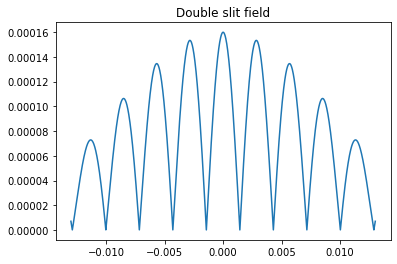

In [69]:
plt.plot(y,abs(E_ds(y,a,b)))
plt.title("Double slit field")

Text(0.5, 1.0, 'Double-Gaussian field')

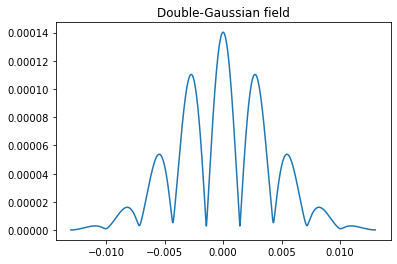

In [70]:
plt.plot(y,abs(E_dg(y,a,b)))
plt.title("Double-Gaussian field")

## Define a single function to explore the FFT:

In [71]:
def plotFFT(d,a,b):
    """Single function version of generating the FFT output"""
    TotalField = E_dg(y,a,b)+E_lo(y,d)
    TotalIntensity=TotalField*TotalField.conj()
    plt.plot(abs(fft(TotalIntensity)),".-")
    plt.ylim([0,1e-2])
    plt.xlim([0,650])
    plt.title("FFT output")

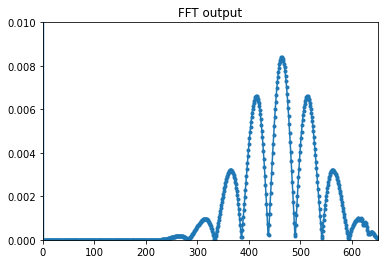

In [72]:
plotFFT(d=0.046,a=0.5e-3,b=0.08e-3)

This agrees well with Matt's code using symbolic calculations. The main difference I see is in the size of the low-frequency peak. It's much smaller here than in his version.

## d=0.035

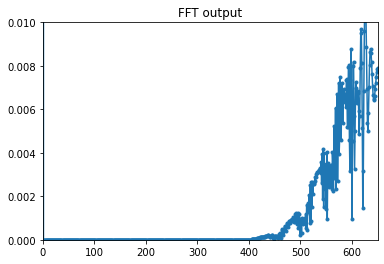

In [73]:
plotFFT(d=0.035,a=0.5e-3,b=0.08e-3)

## d=0.02

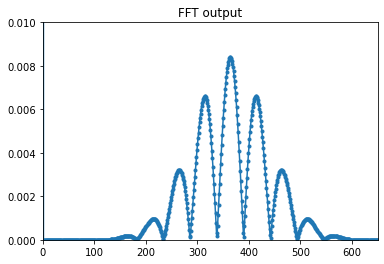

In [74]:
plotFFT(d=0.02,a=0.5e-3,b=0.08e-3)

## Double slit is still very different:

In [75]:
def plotFFTds(d,a,b):
    """Single function version of generating the FFT output"""
    TotalField = E_ds(y,a,b)+E_lo(y,d)
    TotalIntensity=TotalField*TotalField.conj()
    plt.plot(abs(fft(TotalIntensity)),".-")
    plt.ylim([0,0.1])
    plt.xlim([400,500])
    plt.title("FFT output")

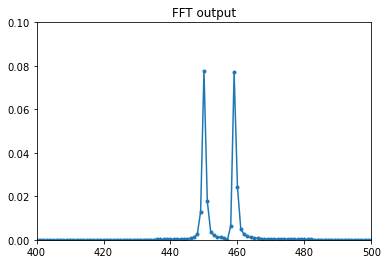

In [76]:
plotFFTds(d=0.025,a=0.5e-3,b=0.08e-3)

This does not agree with experimental results.

### Replace with Gaussian LO: import gaussian beam function, and repeat:

In [83]:
bopt.gaussian_beam?

In [90]:
# bopt.gaussian_beam(x, y, z, E0, wavelambda, w0, k)
# set to evaluate gaussian at L (full distance to CCD) with waist width of 2 cm
# using d=0.046 for agreement with experiment
d=0.046
E_lo_gauss = bopt.gaussian_beam(0,y,L,E0=1,wavelambda=795e-9,w0=0.02,k=[0,k*d/L,k])

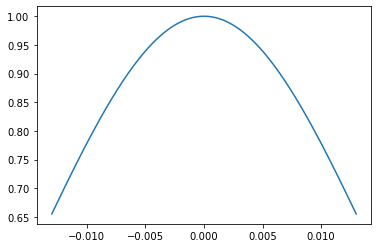

In [91]:
plt.plot(y,abs(E_lo_gauss))

In [92]:
TotalIntensity=(E_dg(y,a,b)+E_lo_gauss) * (E_dg(y,a,b)+E_lo_gauss).conj()

/home/photon/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


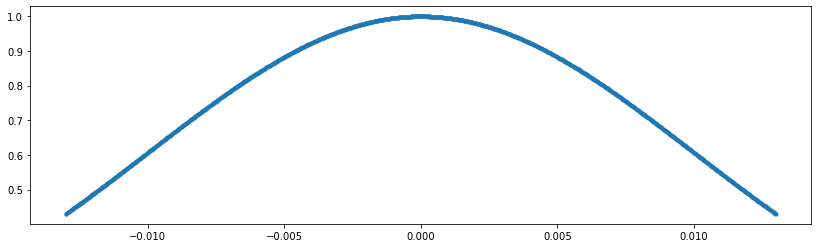

In [93]:
plt.figure(figsize=(14,4))
plt.plot(y,TotalIntensity,".-")

#plt.xlim([-.002,0])

(0.0, 650.0)

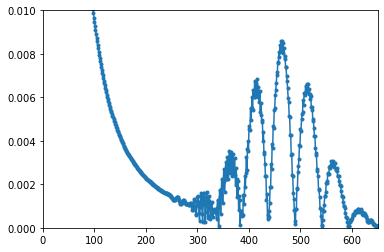

In [97]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,0.01]) # Had to lower the LO power quite a bit, and then zoom way in.

plt.xlim([0,650])